In [1]:
#TODO:
#See about importing a notebook from a notebook and if possible move functions to their own module
#Homogenize df manipulation functions s.t. new attributes from lists are updated within the function
#Don't make a new dataframe every other cell

#What we could look at, instead of ALL wins by passer differential
#Is positive differential with two classes, wins and losses

In [2]:
#The goal of this notebook is to evaluate Passer Rating differential vs game outcome. 
#Intuition suggests that if one guy throws better than the other guy, his team probably wins

In [157]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import math
import numpy as np
import duckdb

In [4]:
playlist1 = pd.read_csv('playlist_1.csv')
playlist2 = pd.read_csv('playlist_2.csv')
players   = pd.read_csv('playerlist.csv')
teams     = pd.read_csv('teamlist.csv')

/tmp/ipykernel_44618/31602283.py:1: DtypeWarning: Columns (46,180,181,183,184,190,191,204,205,206,207,214,215,219,220,221,223,225,227,244,245,246,249,250,254,255,256,261,263,264,267,268,269,270,278,284,285,302) have mixed types. Specify dtype option on import or set low_memory=False.
  playlist1 = pd.read_csv('playlist_1.csv')
/tmp/ipykernel_44618/31602283.py:2: DtypeWarning: Columns (46,180,181,183,184,190,191,194,195,198,199,204,205,206,207,219,220,221,223,225,227,249,250,254,255,256,261,263,264,278,284,285,302,373,374,375,376,378,380,381,382) have mixed types. Specify dtype option on import or set low_memory=False.
  playlist2 = pd.read_csv('playlist_2.csv')


In [5]:
#NOTE:
#Due to the file size limit on GitHub, the data for the 2022 NFL season is stored in two separate CSV files.
#They are rebuilt into a single dataframe, 'DFPL', in this cell. The index column is dropped. 


playlist = [playlist1, playlist2]
DFPL = pd.concat(playlist)
DFPL = DFPL.drop(DFPL.columns[[0]], axis=1)

In [6]:
#COMMENTARY:
#The first step in our evaluation is to select only the relevant plays from the 2022 season.
#We have chosen to only analyze the regular season, excluding plays from the pre and post seasons.
#This was done because the post season has fewer QBs, and the preseason, well most people don't really try

#We have also excluded two point attempts, as the completion rates tend to be much lower than normal plays

#Finally we have excluded non passing plays, to shrink up the size of the data set. 

#Our dataframe is now limited to the relevant passing plays from the 2022 regular season.

In [7]:
DFqb = DFPL[DFPL["season_type"] == "REG"]
DFqb = DFqb[DFqb["two_point_attempt"] == False]
DFqb = DFqb[DFqb["play_type"] == "pass"]
#DFqb.shape outputs (19305, 384)

In [8]:
#NOTE:
#The passing player's name is not stored in our primary dataframe ('DFqb'), but it is stored in 'players'
#We use the following cell to extract the plassing player's name from the 'players' dataframe
#Then we print out the unique values, to see the names of everyone in our primary dataframe who had thrown a pass

DFqb = DFqb.merge(players[["player_id", "player_name"]], 
                            left_on="passer_player_id", right_on="player_id")

DFqb["player_name"].unique() 

array(['Joe Flacco', 'Lamar Jackson', 'Josh Allen', 'Matthew Stafford',
       'Baker Mayfield', 'Jacoby Brissett', 'Geno Smith',
       'Russell Wilson', 'Kirk Cousins', 'Aaron Rodgers', 'Jordan Love',
       'Matt Ryan', 'Davis Mills', 'Trevor Lawrence', 'Carson Wentz',
       'Patrick Mahomes', 'Kyler Murray', 'Trace McSorley',
       'Justin Herbert', 'Derek Carr', 'Davante Adams', 'Mac Jones',
       'Tua Tagovailoa', 'Marcus Mariota', 'Jameis Winston',
       'Ryan Tannehill', 'Daniel Jones', 'Jared Goff', 'Jalen Hurts',
       'Mitchell Trubisky', 'Joe Burrow', 'Justin Fields', 'Trey Lance',
       'Dak Prescott', 'Tom Brady', 'Cooper Rush', 'Braden Mann',
       'Jimmy Garoppolo', 'DeeJay Dallas', 'Malik Willis', 'Case Keenum',
       'Teddy Bridgewater', 'Tommy Townsend', 'Mack Hollins',
       'Tyrod Taylor', 'Tyler Boyd', 'Andy Dalton', 'Ryan Wright',
       'Brian Hoyer', 'Bailey Zappe', 'Zach Wilson', 'Braxton Berrios',
       'Kenny Pickett', 'Jack Fox', 'Justin Jefferson

In [9]:
#NOTE:
#We want to pull the team color, because it could be fun for visualization purposes
#Color isn't available from "the playlist" but it is available from "teams"

DFqb = DFqb.merge(teams[["team_abbr", "team_color"]],
                                   left_on="posteam", right_on="team_abbr")

In [10]:
#COMMENTARY:
#For the purposes of our work we want to isolate the relevant attributes into a new primary (dfPR)
#We want to work towards one passer rating per team per week

dfPR = (DFqb.groupby(["player_name", "team_abbr", "team_color", "week", "defteam"], as_index=False)
         .agg({"passing_yards": "sum", "pass_touchdown": "sum", "interception": "sum", 
               "pass_attempt": "sum", "complete_pass": "sum"})
         )
#COMMENTARY:
#This has everything we need for Passer Rating. Now we'll make a function to take the relevant info per week
#and calculate the Passer Rating and store that value in the aptly named passer_rating attribute

In [11]:
#NOTE:
#The Passer Rating formula is ((a+b+c+d)/6)*100
#The values of a through d are demonstrated in the calculatePasserRating function in the next cell

#Part of the formula is that if any value a through d is less than 0, it is set to 0
#and if it is above 2.375, it is set to 2.375
#This ultimately makes the worst possible Passer Rating 0, and best possible 158.3

#The function in this cell enforces the upper and lower bounds

def prHelper(value):
    if value < 0:
        value = 0
    if value > 2.375:
        value = 2.375
    return value

In [12]:
def calculatePasserRating(df):
    passerRating = []
    for index, qb in df.iterrows():
        completions = qb["complete_pass"]
        attempts    = qb["pass_attempt"]
        touchdowns  = qb["pass_touchdown"]
        yards       = qb["passing_yards"]
        ints        = qb["interception"]
        
        #IDEA ###############################################################################################
        #The weights and biases below are originally from values from the 1960-1970 NFL seasons.
        #An idea for later analysis would be to modify these such that the season averages for a, b, c, and d
        #equal 1. The intention of the original formula was that a passer rating of 67 would be average.
        #The actual average values these days are closer to 90. 
        
        a = ((completions/attempts) - .3) * 5
        b = ((yards/attempts) - 3) * .25
        c = (touchdowns/attempts) * 20
        d = 2.375 - ((ints/attempts) * 25)
        
        a = prHelper(a)
        b = prHelper(b)
        c = prHelper(c)
        d = prHelper(d)
             
        pr = ((a+b+c+d)/6) * 100
        
        #NOTE ##########
        #We could perform the rounding in prHelper() as well if it brings these ratings in line with their
        #known values
        pr = round(pr, 1)
             
        passerRating.append(pr)
             
    return passerRating
        

In [13]:
#Now that the function is built we can create a list to store the values, then we will declare that list as a column
prList = calculatePasserRating(dfPR)
dfPR["passer_rating"] = prList

In [14]:
dfPR

,player_name,team_abbr,team_color,week,defteam,passing_yards,pass_touchdown,interception,pass_attempt,complete_pass,passer_rating
0,Aaron Rodgers,GB,#203731,1,MIN,195.0,0.0,1.0,38.0,22.0,60.7
1,Aaron Rodgers,GB,#203731,2,CHI,234.0,2.0,0.0,28.0,19.0,117.3
2,Aaron Rodgers,GB,#203731,3,TB,255.0,2.0,1.0,36.0,27.0,101.0
3,Aaron Rodgers,GB,#203731,4,NE,251.0,2.0,1.0,36.0,21.0,86.7
4,Aaron Rodgers,GB,#203731,5,NYG,222.0,2.0,0.0,41.0,25.0,91.7
...,...,...,...,...,...,...,...,...,...,...,...
657,Zach Wilson,NYJ,#003F2D,8,NE,355.0,2.0,3.0,43.0,20.0,61.7
658,Zach Wilson,NYJ,#003F2D,9,BUF,154.0,1.0,0.0,27.0,18.0,93.8
659,Zach Wilson,NYJ,#003F2D,11,NE,77.0,0.0,0.0,26.0,9.0,43.4
660,Zach Wilson,NYJ,#003F2D,15,DET,317.0,2.0,1.0,39.0,18.0,80.8


In [15]:
#Glorious calculations! We can feel confident in our numbers because Zach Wilson is terrible
#and our data reflects this.

#Our next steps are 
#(ONE) Modify the dataframe such that there is one QB per team per week (based on highest passing yards)
#(TWO) Add a column for the passer rating differential (this QB minus opponent QB)

#There should be 272 games in the regular season. 
#32 teams * 17 games = 544. Obviously teams play against each other, so is 272 games
#We're looking for 1 passer per team per game per week, so the final amount of elements should be 544

In [16]:
#NOTE: This function currently only works on sorted input, by team and week ascending, passing yards descending
#IDEA: Later iterations should allow for unsorted incoming data, and sort the data as needed


#COMMENTARY:
#The logic for this function is as follows
#For every entry (QB)
#    If the "last QB"'s name is different, but the team and the week are the same
#        If this QB has less passing yards than the "last QB", drop this entry
#    Else, update the values for "last QB"
def weeklyPassingLeadersOnly(df):
    lastWeek = 0
    lastQB = "Nobody"
    lastTeam = "Nobodies"
    lastYards = 0
    
    for index, qb in df.iterrows():
        thisWeek = qb["week"]
        thisQB   = qb["player_name"]
        thisTeam = qb["team_abbr"]
        currYards= qb["passing_yards"]
        
        if((thisQB!=lastQB) and (thisTeam==lastTeam) and (thisWeek==lastWeek) ):
            if(currYards < lastYards):
                df.drop(index, inplace=True)
        else:
            lastWeek = thisWeek
            lastQB   = thisQB
            lastTeam = thisTeam
            lastYards= currYards             
    return df

In [17]:
dfPRSorted = dfPR.sort_values(["team_abbr", "week", "passing_yards"], ascending = [True, True, False])
dfPRFiltered = weeklyPassingLeadersOnly(dfPRSorted)
dfPRFiltered

,player_name,team_abbr,team_color,week,defteam,passing_yards,pass_touchdown,interception,pass_attempt,complete_pass,passer_rating
385,Kyler Murray,ARI,#97233F,1,KC,193.0,2.0,0.0,36.0,22.0,93.9
386,Kyler Murray,ARI,#97233F,2,LV,277.0,1.0,1.0,50.0,31.0,75.2
387,Kyler Murray,ARI,#97233F,3,LA,314.0,0.0,0.0,60.0,37.0,75.3
388,Kyler Murray,ARI,#97233F,4,CAR,207.0,2.0,1.0,33.0,23.0,93.9
389,Kyler Murray,ARI,#97233F,5,PHI,250.0,1.0,1.0,41.0,28.0,82.4
...,...,...,...,...,...,...,...,...,...,...,...
567,Taylor Heinicke,WAS,#5A1414,13,NYG,275.0,2.0,0.0,46.0,27.0,90.4
568,Taylor Heinicke,WAS,#5A1414,15,NYG,249.0,1.0,0.0,32.0,17.0,89.2
569,Taylor Heinicke,WAS,#5A1414,16,SF,166.0,2.0,1.0,20.0,13.0,103.3
80,Carson Wentz,WAS,#5A1414,17,CLE,143.0,0.0,3.0,31.0,16.0,24.7


In [18]:
#NOTE:
#We actually end up with 542 entries. With 32 teams playing 17 games in the regular season, we should end up
#with 544. After some thought, and a brief check of the data, one game is absent, resulting in 542 elements
#in the data set. This is because one game was cancelled after a player had a heart attack on the field. 

#COMMENTARY:
#We have one qb per team per week. 
#We now need to include the opposing team's QB's passer rating from that week

In [19]:
#COMMENTARY:
#The idea for this function is to generate a list with the same length as the primary dataframe, that is
#composed of the opposition's passer rating from each week from each game

#NOTE:
#The logic of this function is as follows
#For every element (QB)
#    For every element (QB)
#         If inner QB's team is equal to the team outer QB played against during the same week
#              Append outer QB's passer rating to a list and break to outer loop

#TODO:
#Figure out a way to do this that isn't O(n^2)

def addDefPR(df):
    
    otherTeamPasserRating = []
    
    
    for index, qb in df.iterrows():
        thisWeek = qb["week"]
        thisTeam = qb["team_abbr"]
        thisDef  = qb["defteam"]
        otherPR  = 0.0
        
        for index2, qb2 in df.iterrows():
            currWeek = qb2["week"]
            currTeam = qb2["team_abbr"]
            
            if(currTeam == thisDef and currWeek == thisWeek):
                otherPR = qb2["passer_rating"]
                otherTeamPasserRating.append(otherPR)
                break
                       
    return otherTeamPasserRating

In [20]:
otherPRList = addDefPR(dfPRFiltered)
dfPRFiltered["other_team_pr"] = otherPRList

In [21]:
#COMMENTARY:
#Now that we have one QB per team per week, their passer rating, and their opponent's passer rating, we can
#establish the passer rating differential.

In [22]:
#NOTE:
#The logic of this function is as follows:
#For every element (QB), subtract the opposing QB's passer rating from this passer rating, and append that value
#to a list
#Then update the dataframe to include the passer rating differential attribute
def addPasserDifferential(df):
    passerDifferential = []
    for index, qb in df.iterrows():
        thisPR = qb["passer_rating"]
        thatPR = qb["other_team_pr"]
        diff = thisPR - thatPR
        passerDifferential.append(diff)
    
    df["differential"] = passerDifferential
    
    return df
        

In [23]:
dfPRFiltered = addPasserDifferential(dfPRFiltered)
dfPRFiltered

,player_name,team_abbr,team_color,week,defteam,passing_yards,pass_touchdown,interception,pass_attempt,complete_pass,passer_rating,other_team_pr,differential
385,Kyler Murray,ARI,#97233F,1,KC,193.0,2.0,0.0,36.0,22.0,93.9,144.2,-50.3
386,Kyler Murray,ARI,#97233F,2,LV,277.0,1.0,1.0,50.0,31.0,75.2,97.1,-21.9
387,Kyler Murray,ARI,#97233F,3,LA,314.0,0.0,0.0,60.0,37.0,75.3,99.7,-24.4
388,Kyler Murray,ARI,#97233F,4,CAR,207.0,2.0,1.0,33.0,23.0,93.9,58.8,35.1
389,Kyler Murray,ARI,#97233F,5,PHI,250.0,1.0,1.0,41.0,28.0,82.4,85.3,-2.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Taylor Heinicke,WAS,#5A1414,13,NYG,275.0,2.0,0.0,46.0,27.0,90.4,100.6,-10.2
568,Taylor Heinicke,WAS,#5A1414,15,NYG,249.0,1.0,0.0,32.0,17.0,89.2,77.6,11.6
569,Taylor Heinicke,WAS,#5A1414,16,SF,166.0,2.0,1.0,20.0,13.0,103.3,101.1,2.2
80,Carson Wentz,WAS,#5A1414,17,CLE,143.0,0.0,3.0,31.0,16.0,24.7,104.9,-80.2


In [24]:
#COMMENTARY:
#We now have the first part of the original plan resolved, that is, one QB per week and the passer rating
#differential. For the second part, we need to know the outcome of each game. 

#I've hand made a file for these purposes with attributes:
#Week, Away, Home, AwayScore, HomeScore, and Winner
#In the event of a tie, winner is recorded as TIE
#We are going to use this information to store the Winner of each game, per QB per week. 


In [25]:
dfGames     = pd.read_csv("regularSeasonGameOutcomes2022.csv")

In [26]:
dfPRFiltered
#COMMENTARY:
#So we want to join on week = week AND team_abbr = Away OR team_abbr = Home
#Conditional joins seem like they'd be a lot easier with SQL, lets try out DuckDB

,player_name,team_abbr,team_color,week,defteam,passing_yards,pass_touchdown,interception,pass_attempt,complete_pass,passer_rating,other_team_pr,differential
385,Kyler Murray,ARI,#97233F,1,KC,193.0,2.0,0.0,36.0,22.0,93.9,144.2,-50.3
386,Kyler Murray,ARI,#97233F,2,LV,277.0,1.0,1.0,50.0,31.0,75.2,97.1,-21.9
387,Kyler Murray,ARI,#97233F,3,LA,314.0,0.0,0.0,60.0,37.0,75.3,99.7,-24.4
388,Kyler Murray,ARI,#97233F,4,CAR,207.0,2.0,1.0,33.0,23.0,93.9,58.8,35.1
389,Kyler Murray,ARI,#97233F,5,PHI,250.0,1.0,1.0,41.0,28.0,82.4,85.3,-2.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Taylor Heinicke,WAS,#5A1414,13,NYG,275.0,2.0,0.0,46.0,27.0,90.4,100.6,-10.2
568,Taylor Heinicke,WAS,#5A1414,15,NYG,249.0,1.0,0.0,32.0,17.0,89.2,77.6,11.6
569,Taylor Heinicke,WAS,#5A1414,16,SF,166.0,2.0,1.0,20.0,13.0,103.3,101.1,2.2
80,Carson Wentz,WAS,#5A1414,17,CLE,143.0,0.0,3.0,31.0,16.0,24.7,104.9,-80.2


In [83]:
#NOTE: Connects to an 'in-memory database'
con = duckdb.connect()

sql = """SELECT *
FROM dfPRFiltered, dfGames
WHERE (dfPRFiltered.team_abbr=dfGames.Away or dfPRFiltered.team_abbr=dfGames.Home)
AND (dfPRFiltered.week = dfGames.Week)"""

#NOTE: Executes query
resultsOutcome = con.execute(sql).df()
resultsOutcome

,player_name,team_abbr,team_color,week,defteam,passing_yards,pass_touchdown,interception,pass_attempt,complete_pass,passer_rating,other_team_pr,differential,Week,Away,Home,AwayScore,HomeScore,Winner
0,Lamar Jackson,BAL,#241773,9,NO,133.0,1.0,0.0,25.0,12.0,77.6,74.1,3.5,9,BAL,NO,27,13,BAL
1,Justin Fields,CHI,#0B162A,7,NE,179.0,1.0,1.0,25.0,13.0,71.9,64.6,7.3,7,CHI,NE,33,14,CHI
2,Joe Burrow,CIN,#FB4F14,8,CLE,232.0,2.0,1.0,40.0,25.0,84.6,128.5,-43.9,8,CIN,CLE,13,32,CLE
3,Cooper Rush,DAL,#002244,3,NYG,215.0,1.0,0.0,31.0,21.0,98.2,51.3,46.9,3,DAL,NYG,23,16,DAL
4,Russell Wilson,DEN,#002244,1,SEA,340.0,1.0,0.0,44.0,29.0,96.8,115.3,-18.5,1,DEN,SEA,16,17,SEA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,Patrick Mahomes,KC,#E31837,2,LAC,235.0,2.0,0.0,36.0,24.0,103.4,96.6,6.8,2,LAC,KC,24,27,KC
538,Matthew Stafford,LA,#003594,1,BUF,240.0,1.0,3.0,48.0,29.0,54.2,109.2,-55.0,1,BUF,LA,31,10,BUF
539,Jarrett Stidham,LV,#000000,18,KC,219.0,1.0,1.0,42.0,22.0,65.5,97.6,-32.1,18,KC,LV,31,13,KC
540,Zach Wilson,NYJ,#003F2D,16,JAX,92.0,0.0,1.0,21.0,9.0,36.2,84.0,-47.8,16,JAX,NYJ,19,3,JAX


In [28]:
#COMMENTARY:
#SQL is a magical wonderful thing
#If we wanted to look at just the winning QBs (elements where team_abbr==Winner)
#For each qb, if team_abbr != Winner, drop row

In [42]:
def dropLosers(df):
    for index, qb in df.iterrows():
        if qb["team_abbr"] != qb["Winner"]:
            df.drop(index, inplace=True)
    return df

In [46]:
winnersOnly = resultsOutcome.copy()
winnersDifferential = dropLosers(winnersOnly)
winnersDifferential.differential.describe()

count    269.000000
mean      19.834944
std       26.847232
min      -90.400000
25%        4.800000
50%       16.800000
75%       35.700000
max       97.700000
Name: differential, dtype: float64

In [37]:
#COMMENTARY:
#So the average winning team's quarterback has a passer rating 19.8 higher than their opponent
#And 50% of winners have at least 16.8 PR higher

posPR = 0
negPR = 0
for index, qb in winnersDifferential.iterrows():
    if(qb["differential"] > 0):
        posPR+=1
    else:
        negPR+=1

negPer = round((negPR/(negPR+posPR))*100,2)
posPer = round((posPR/(negPR+posPR))*100,2)        
        
print(posPR, " teams won with a positive Passer Rating differential")
print("That is ", posPer, "%")
print(negPR, " teams won with a negative Passer Rating differential")
print("That is ", negPer, "%")

218  teams won with a positive Passer Rating differential
That is  81.04 %
51  teams won with a negative Passer Rating differential
That is  18.96 %


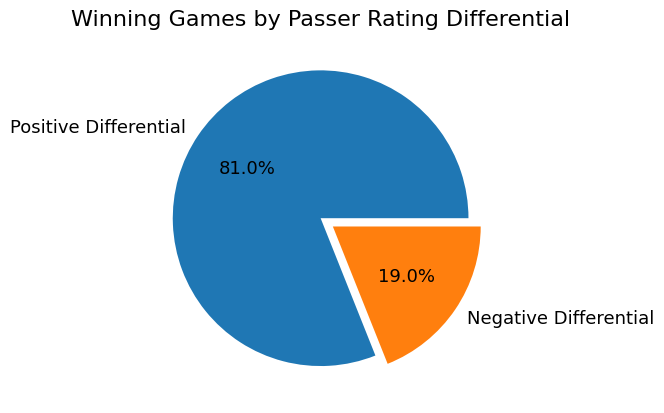

In [38]:
piePercents = np.array([posPR, negPR])
pieLabels = ["Positive Differential", "Negative Differential"]
plt.pie(piePercents, labels = pieLabels, autopct='%1.1f%%', explode=(0, 0.1), textprops = {"fontsize":13})
plt.title('Winning Games by Passer Rating Differential', fontsize=16)
plt.show() 

In [ ]:
#TODO: DOCUMENTATION UNDER THIS VALUE

In [49]:
resultsOutcome.sort_values(["team_abbr", "week"])
#dfPR = (DFqb.groupby(["player_name", "team_abbr", "team_color", "week", "defteam"], as_index=False)
#         .agg({"passing_yards": "sum", "pass_touchdown": "sum", "interception": "sum", 
#               "pass_attempt": "sum", "complete_pass": "sum"})
#         )

,player_name,team_abbr,team_color,week,defteam,passing_yards,pass_touchdown,interception,pass_attempt,complete_pass,passer_rating,other_team_pr,differential,Week,Away,Home,AwayScore,HomeScore,Winner
90,Kyler Murray,ARI,#97233F,1,KC,193.0,2.0,0.0,36.0,22.0,93.9,144.2,-50.3,1,KC,ARI,44,21,KC
180,Kyler Murray,ARI,#97233F,2,LV,277.0,1.0,1.0,50.0,31.0,75.2,97.1,-21.9,2,ARI,LV,29,23,ARI
162,Kyler Murray,ARI,#97233F,3,LA,314.0,0.0,0.0,60.0,37.0,75.3,99.7,-24.4,3,LA,ARI,20,12,LA
144,Kyler Murray,ARI,#97233F,4,CAR,207.0,2.0,1.0,33.0,23.0,93.9,58.8,35.1,4,ARI,CAR,26,16,ARI
126,Kyler Murray,ARI,#97233F,5,PHI,250.0,1.0,1.0,41.0,28.0,82.4,85.3,-2.9,5,PHI,ARI,20,17,PHI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,Taylor Heinicke,WAS,#5A1414,13,NYG,275.0,2.0,0.0,46.0,27.0,90.4,100.6,-10.2,13,WAS,NYG,20,20,TIE
71,Taylor Heinicke,WAS,#5A1414,15,NYG,249.0,1.0,0.0,32.0,17.0,89.2,77.6,11.6,15,NYG,WAS,20,12,NYG
233,Taylor Heinicke,WAS,#5A1414,16,SF,166.0,2.0,1.0,20.0,13.0,103.3,101.1,2.2,16,WAS,SF,20,37,SF
251,Carson Wentz,WAS,#5A1414,17,CLE,143.0,0.0,3.0,31.0,16.0,24.7,104.9,-80.2,17,CLE,WAS,24,10,CLE


In [57]:
resultsOutcome2 = (resultsOutcome.groupby(["player_name", "team_abbr", "team_color"], as_index=False)
         .agg({"differential": "mean"})
         )
resultsOutcome2

#So take this, get a wins and losses from the dfGames, then look at okay with X avg differential
#Outcome is Y percentage of games won

,player_name,team_abbr,team_color,differential
0,Aaron Rodgers,GB,#203731,9.382353
1,Andy Dalton,NO,#D3BC8D,12.792857
2,Anthony Brown,BAL,#241773,-33.100000
3,Bailey Zappe,NE,#002244,24.525000
4,Baker Mayfield,CAR,#0085CA,-13.771429
...,...,...,...,...
62,Trevor Siemian,CHI,#0B162A,-75.200000
63,Trey Lance,SF,#AA0000,-29.800000
64,Tua Tagovailoa,MIA,#008E97,11.108333
65,Tyler Huntley,BAL,#241773,-4.980000


In [58]:
resultsOutcome

,player_name,team_abbr,team_color,week,defteam,passing_yards,pass_touchdown,interception,pass_attempt,complete_pass,passer_rating,other_team_pr,differential,Week,Away,Home,AwayScore,HomeScore,Winner
0,Lamar Jackson,BAL,#241773,9,NO,133.0,1.0,0.0,25.0,12.0,77.6,74.1,3.5,9,BAL,NO,27,13,BAL
1,Justin Fields,CHI,#0B162A,7,NE,179.0,1.0,1.0,25.0,13.0,71.9,64.6,7.3,7,CHI,NE,33,14,CHI
2,Joe Burrow,CIN,#FB4F14,8,CLE,232.0,2.0,1.0,40.0,25.0,84.6,128.5,-43.9,8,CIN,CLE,13,32,CLE
3,Cooper Rush,DAL,#002244,3,NYG,215.0,1.0,0.0,31.0,21.0,98.2,51.3,46.9,3,DAL,NYG,23,16,DAL
4,Russell Wilson,DEN,#002244,1,SEA,340.0,1.0,0.0,44.0,29.0,96.8,115.3,-18.5,1,DEN,SEA,16,17,SEA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,Patrick Mahomes,KC,#E31837,2,LAC,235.0,2.0,0.0,36.0,24.0,103.4,96.6,6.8,2,LAC,KC,24,27,KC
538,Matthew Stafford,LA,#003594,1,BUF,240.0,1.0,3.0,48.0,29.0,54.2,109.2,-55.0,1,BUF,LA,31,10,BUF
539,Jarrett Stidham,LV,#000000,18,KC,219.0,1.0,1.0,42.0,22.0,65.5,97.6,-32.1,18,KC,LV,31,13,KC
540,Zach Wilson,NYJ,#003F2D,16,JAX,92.0,0.0,1.0,21.0,9.0,36.2,84.0,-47.8,16,JAX,NYJ,19,3,JAX


In [105]:
#if team_abbr == Winner, Wins+=1, elif team_abbr == "TIE", Ties += 1, else Losses += 1

#sort by player_name
#df["Wins"] = 0, df["losses]=0, ties=0, SEE IF THIS DEFAULTS THEM ALL TO ZERO
#itterQB = first row['player-name']
#for index, qb
# wins,losses,ties=0
# if player_name == itterQB
#      if team_abbr == Winner, Wins+=1, elif team_abbr == "TIE", Ties += 1, else Losses += 1
# else, 
#    qb[Wins] = wins, qb[Ties] = ties, qb[Losses] = losses
#    wins, losses, ties=0
#    itterQB = qb['player-name']
def addRecord(df):
    df = df.sort_values(["player_name"])
    
    df["Won"] = 0
    df["Lost"] = 0
    df["Tied"] = 0
    
    iterQB = df.iloc[0]["player_name"]
    
    print(iterQB, " STARTING QB")
    
    for index, qb in df.iterrows():
        if (qb["player_name"] == iterQB):
            if (qb["team_abbr"] == qb["Winner"]):
                df.at[index, "Won"] = 1
            elif (qb["Winner"] == "TIE"):
                df.at[index, "Tied"] = 1
            else:
                df.at[index, "Lost"] = 1
        else:
            iterQB = qb["player_name"]
            if (qb["team_abbr"] == qb["Winner"]):
                df.at[index, "Won"] = 1
            elif (qb["Winner"] == "TIE"):
                df.at[index, "Tied"] = 1
            else:
                df.at[index, "Lost"] = 1

                   
    
    return df

In [109]:
dfQBDifRec = addRecord(resultsOutcome)
#dfQBDifRec = dfQBDifRec.groupby(["player_name"])
dfQBDifRec

Aaron Rodgers  STARTING QB


,player_name,team_abbr,team_color,week,defteam,passing_yards,pass_touchdown,interception,pass_attempt,complete_pass,...,differential,Week,Away,Home,AwayScore,HomeScore,Winner,Won,Lost,Tied
94,Aaron Rodgers,GB,#203731,10,DAL,224.0,3.0,0.0,22.0,14.0,...,61.7,10,DAL,GB,28,31,GB,1,0,0
368,Aaron Rodgers,GB,#203731,9,DET,291.0,1.0,3.0,44.0,23.0,...,-26.1,9,GB,DET,9,15,DET,0,1,0
95,Aaron Rodgers,GB,#203731,17,MIN,159.0,1.0,0.0,24.0,15.0,...,50.1,17,MIN,GB,17,41,GB,1,0,0
294,Aaron Rodgers,GB,#203731,13,CHI,182.0,1.0,0.0,31.0,18.0,...,10.0,13,GB,CHI,28,19,GB,1,0,0
93,Aaron Rodgers,GB,#203731,4,NE,251.0,2.0,1.0,36.0,21.0,...,-3.1,4,NE,GB,24,27,GB,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,Zach Wilson,NYJ,#003F2D,4,PIT,252.0,1.0,2.0,37.0,18.0,...,-7.6,4,NYJ,PIT,24,20,NYJ,1,0,0
319,Zach Wilson,NYJ,#003F2D,9,BUF,154.0,1.0,0.0,27.0,18.0,...,52.7,9,BUF,NYJ,17,20,NYJ,1,0,0
318,Zach Wilson,NYJ,#003F2D,5,MIA,210.0,0.0,0.0,23.0,14.0,...,35.7,5,MIA,NYJ,17,40,NYJ,1,0,0
228,Zach Wilson,NYJ,#003F2D,6,GB,110.0,0.0,0.0,20.0,10.0,...,-13.7,6,NYJ,GB,27,10,NYJ,1,0,0


In [110]:
dfQBDifRec2 = (dfQBDifRec.groupby(["player_name", "team_abbr", "team_color"], as_index=False)
         .agg({"Won": "sum", "Lost": "sum", "Tied": "sum", 
               "passer_rating": "mean", "differential": "mean"})
         )
dfQBDifRec2

,player_name,team_abbr,team_color,Won,Lost,Tied,passer_rating,differential
0,Aaron Rodgers,GB,#203731,8,9,0,88.323529,9.382353
1,Andy Dalton,NO,#D3BC8D,6,8,0,88.850000,12.792857
2,Anthony Brown,BAL,#241773,0,1,0,44.300000,-33.100000
3,Bailey Zappe,NE,#002244,2,2,0,91.575000,24.525000
4,Baker Mayfield,CAR,#0085CA,1,6,0,72.628571,-13.771429
...,...,...,...,...,...,...,...,...
62,Trevor Siemian,CHI,#0B162A,0,1,0,69.800000,-75.200000
63,Trey Lance,SF,#AA0000,0,1,0,47.100000,-29.800000
64,Tua Tagovailoa,MIA,#008E97,8,4,0,102.200000,11.108333
65,Tyler Huntley,BAL,#241773,3,2,0,76.520000,-4.980000


In [113]:
#win percentage as new column
def getWinPercentage(df):
    df["Win%"] = 0.0
    for index, qb in df.iterrows():
        winPerc = qb["Won"] / (qb["Won"] + qb["Lost"] + qb["Tied"]) * 100
        df.at[index, "Win%"] = round(winPerc, 2)
    return df
dfQBDifRec3 = getWinPercentage(dfQBDifRec2)
dfQBDifRec3

,player_name,team_abbr,team_color,Won,Lost,Tied,passer_rating,differential,Win%
0,Aaron Rodgers,GB,#203731,8,9,0,88.323529,9.382353,47.06
1,Andy Dalton,NO,#D3BC8D,6,8,0,88.850000,12.792857,42.86
2,Anthony Brown,BAL,#241773,0,1,0,44.300000,-33.100000,0.00
3,Bailey Zappe,NE,#002244,2,2,0,91.575000,24.525000,50.00
4,Baker Mayfield,CAR,#0085CA,1,6,0,72.628571,-13.771429,14.29
...,...,...,...,...,...,...,...,...,...
62,Trevor Siemian,CHI,#0B162A,0,1,0,69.800000,-75.200000,0.00
63,Trey Lance,SF,#AA0000,0,1,0,47.100000,-29.800000,0.00
64,Tua Tagovailoa,MIA,#008E97,8,4,0,102.200000,11.108333,66.67
65,Tyler Huntley,BAL,#241773,3,2,0,76.520000,-4.980000,60.00


In [ ]:
#DANGER: UNDER CONSTRUCTION

In [ ]:
#TODO: LOTS
#Also, get the passer rating and differentials as .## format

In [209]:
def showAVGPRvsWinPerc(df):
    fig = go.Figure()

    for name, values in df.groupby("player_name"):
        if (values["Win%"].sum() > 0):
            fig.add_trace(
                go.Scatter(
                    x=round(values["passer_rating"],2),
                    y=values["Win%"],
                    name=name,
                    mode="markers",
                    line_color=values.iloc[0].team_color,
                    hovertemplate=f"<b>{name}</b><br>%{{y}}% win rate with %{{x}} Passer Rating<extra></extra>"
                )
            )

        
    fig.update_layout(
        font_family="Averta, sans-serif",
        hoverlabel_font_family="Averta, sans-serif",
        xaxis_title_text="Passer Rating",
        xaxis_title_font_size=18,
        xaxis_tickfont_size=16,
        yaxis_title_text="Win Percentage",
        yaxis_title_font_size=18,
        yaxis_tickfont_size=16,
        hoverlabel_font_size=16,
        legend_font_size=16,
        height=1000,
        width=1000
    )

    fig.show()

In [210]:
def showDiffvsWinPerc(df):
    fig = go.Figure()

    for name, values in df.groupby("player_name"):
        if (values["Win%"].sum() > 0):
            fig.add_trace(
                go.Scatter(
                    x=round(values["differential"],2),
                    y=values["Win%"],
                    name=name,
                    mode="markers",
                    line_color=values.iloc[0].team_color,
                    hovertemplate=f"<b>{name}</b><br>%{{y}}% win rate with %{{x}} Passer Rating Differential<extra></extra>"
                )
            )

        
    fig.update_layout(
        font_family="Averta, sans-serif",
        hoverlabel_font_family="Averta, sans-serif",
        xaxis_title_text="Passer Rating Differential",
        xaxis_title_font_size=18,
        xaxis_tickfont_size=16,
        yaxis_title_text="Win Percentage",
        yaxis_title_font_size=18,
        yaxis_tickfont_size=16,
        hoverlabel_font_size=16,
        legend_font_size=16,
        height=1000,
        width=1000
    )

    fig.show()

In [211]:
showAVGPRvsWinPerc(dfQBDifRec3)

In [212]:
showDiffvsWinPerc(dfQBDifRec3)

In [223]:
#dfQBDifRec4 = dfQBDifRec3[dfQBDifRec3["Win%"]>0]
#dfQBDifRec4

In [229]:
#No legend
#Remove text labels from points
dfQBDifRec4 = dfQBDifRec3[dfQBDifRec3["Win%"]>0]
def plotlyexpress1(df):
    fig = px.scatter(df, x="passer_rating", 
                     y="Win%", trendline="ols", 
                     trendline_scope="overall", 
                     #text=df["player_name"],
                     hover_name="player_name"
                    )
    
    
    fig.update_layout(
        font_family="Averta, sans-serif",
        hoverlabel_font_family="Averta, sans-serif",
        xaxis_title_text="Passer Rating Differential",
        xaxis_title_font_size=18,
        xaxis_tickfont_size=16,
        yaxis_title_text="Win Percentage",
        yaxis_title_font_size=18,
        yaxis_tickfont_size=16,
        hoverlabel_font_size=16,
        legend_font_size=16,
        height=1000,
        width=1000
    )    
    
    
    fig.show()
plotlyexpress1(dfQBDifRec4)

In [217]:
def plotlyexpress2(df):
    fig = px.scatter(df, x="differential", y="Win%", color="team_color", trendline="ols", trendline_scope="overall")
    fig.show()
plotlyexpress2(dfQBDifRec4)

In [182]:
#Not visualized with team color
#Baker Mayfield double dipping
#No legend
#Not all bars labelled
#Mouseover values are not pretty
fig = px.bar(dfQBDifRec3.sort_values(["passer_rating"]), x='player_name', y='passer_rating')
fig.update_layout(
        font_family="Averta, sans-serif",
        hoverlabel_font_family="Averta, sans-serif",
        xaxis_title_text="Quarterback",
        xaxis_title_font_size=18,
        xaxis_tickfont_size=16,
        yaxis_title_text="Passer Rating",
        yaxis_title_font_size=18,
        yaxis_tickfont_size=16,
        hoverlabel_font_size=16,
        legend_font_size=16,
        height=1000,
        width=1000
    )
fig.show()

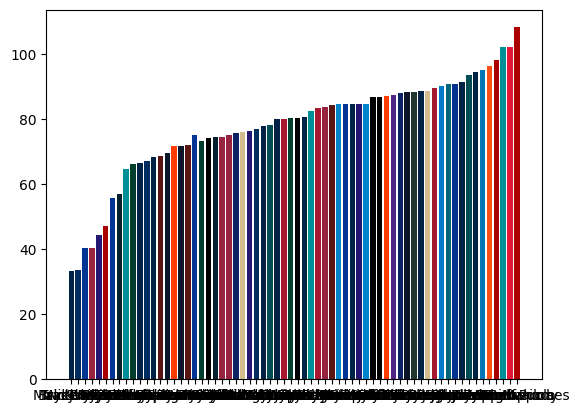

In [197]:
#Completely unreadable x axis labels
#No legend
#No mouseover values
#Baker mayfield double dipping
testDF1 = dfQBDifRec3.sort_values(["passer_rating"]).copy()
testList1 = testDF1["team_color"].values.tolist()
testList1
plt.bar(testDF1["player_name"], testDF1["passer_rating"], color=testList1)
plt.show()